In [2]:
# pip install pulp

In [3]:
from pulp import LpMaximize, LpProblem, LpStatus, lpSum, LpVariable, LpMinimize
import numpy as np
import matplotlib.pyplot as plt
from random import randrange

In [4]:
def MSL_optimization(p0, delta, umin_list):
    p0_val = np.maximum(p0, 1 - p0)
    h_inf = (-1)*np.log2(p0_val)
    fixed_val = h_inf + np.log2(p0)
    epsilon = 10e-10
    
    p1valMSL = [100] * len(umin_list)
    p2valMSL = [100] * len(umin_list)
    MSLval_MSL = [100] * len(umin_list)
    MOLcorrespondval_MSL = [100] * len(umin_list)
    MCBval_MSL = [100] * len(umin_list)
    
    for i in range(len(umin_list)):
        umin = umin_list[i]
    
        # Green sub-region
        model = LpProblem(name = "green-region", sense = LpMinimize)
    
        #100 indicates No solution 
        p1g = 100
        p2g = 100
        MSLg = 100
        MOLg = 100
        MCBg = 100
    
        p1green = LpVariable(name = "p1green", lowBound = 0, upBound = 1)
        p2green = LpVariable(name = "p2green", lowBound = 0, upBound = 1)
    
        q1green = p1green - delta
        q2green = p2green - delta
    
        model += (p0 * p1green + (1 - p0) * p2green >= umin, "utility_constraint_green")
        model += (p1green * p0 <= (1 - p2green)*(1 - p0) - delta, "constraint1_green")
        model += (p2green * (1 - p0) <= p0 * (1 - p1green) - delta, "constraint2_green")
    
        obj_func = 1 - p2green + delta + (p0 * p2green) - (p0 * p1green)
    
        model += obj_func
    
        status = model.solve()
    
        if(model.status == 1):
            p1g = p1green.varValue
            p2g = p2green.varValue
            q1g = p1g - delta
            q2g = p2g - delta
        
            MSLg = h_inf + np.log2(1 - q2g + (p0 * q2g) - (p0 * q1g))
            MOLg = h_inf + np.log2(1 - p2g + (p0 * p2g) - (p0 * p1g))
        
        # Magneta sub-region
        MSLm1 = 100
    
        q11magenta = LpVariable(name = "q11magenta", lowBound = 0, upBound = 1)
        q21magenta = LpVariable(name = "q21magenta", lowBound = 0, upBound = 1)
        p11magenta = q11magenta + delta
        p21magenta = q21magenta + delta
    
        model = LpProblem(name = "magenta-region-1", sense = LpMaximize)
    
        model += (p0 * p11magenta + (1 - p0) * p21magenta >= umin, "utility_constraint_magenta_1")
        model += (((1 - p21magenta)*(1 - p0)) >= (p11magenta*p0), "constraint1_magenta_1")
        model += ((p0*p11magenta) >= (((1 - p21magenta)*(1 - p0)) - delta), "constraint3_magenta_1")
        model += ((p21magenta*(1 - p0)) <= ((p0*(1 - p11magenta)) - delta), "constraint4_magenta_1")
    
        obj_func = 1 - q21magenta + (p0*q21magenta) - (p0*q11magenta)
    
        model += obj_func
    
        status = model.solve()
    
        if(model.status == 1):
            MSLm1 = h_inf + np.log2(1 - q21magenta.varValue + (p0 * q21magenta.varValue) - (p0 * q11magenta.varValue))
        
        if(MSLm1 >= fixed_val):
            p1m = 100
            p2m = 100
            MSLm = 100
            MOLm = 100
        
            p1magenta = LpVariable(name = "p1magenta", lowBound = 0, upBound = 1)
            p2magenta = LpVariable(name = "p2magenta", lowBound = 0, upBound = 1)
        
            q1magenta = p1magenta - delta
            q2magenta = p2magenta - delta
        
            model = LpProblem(name = "magenta-region-3", sense = LpMinimize)
    
            model += (p0 * p1magenta + (1 - p0) * p2magenta >= umin, "utility_constraint_magenta_3")
            model += (((1 - p2magenta)*(1 - p0)) >= (p1magenta*p0), "constraint1_magenta_3")
            model += ((p0*p1magenta) >= (((1 - p2magenta)*(1 - p0)) - delta), "constraint3_magenta_3")
            model += ((p2magenta*(1 - p0)) <= ((p0*(1 - p1magenta)) - delta), "constraint4_magenta_3")
        
            obj_func = 1 - q2magenta + (p0*q2magenta) - (p0*q1magenta)
    
            model += obj_func
    
            status = model.solve()
        
            if(model.status == 1):
                p1m = p1magenta.varValue
                p2m = p2magenta.varValue
                q1m = p1m - delta
                q2m = p2m - delta
                MSLm = h_inf + np.log2(1 - q2m + (p0*q2m) - (p0*q1m))
                MOLm = h_inf + np.log2(1 - p2m + (p0*p2m) - (p0*p1m))
            
        else:        
            MSLm = fixed_val
            MOLm = fixed_val
            p1m = math.nan
            p2m = math.nan
        
        # Black Sub-region
        MSLb1 = 100
    
        q11black = LpVariable(name = "q11black", lowBound = 0, upBound = 1)
        q21black = LpVariable(name = "q21black", lowBound = 0, upBound = 1)
        p11black = q11black + delta
        p21black = q21black + delta
    
        model = LpProblem(name = "black-region-1", sense = LpMaximize)
    
        model += (p0 * p11black + (1 - p0) * p21black >= umin, "utility_constraint_black_1")
        model += ((p0*p11black) >= ((1 - p21black)*(1 - p0)), "constraint2_black_1")
        model += ((p0*p11black) <= (((1 - p21black)*(1 - p0)) + delta), "constraint3_black_1")
        model += ((p21black*(1 - p0)) <= ((p0*(1 - p11black)) - delta), "constraint4_black_1")
    
        obj_func = 1 - q21black + (p0*q21black) - (p0*q11black)
    
        model += obj_func
    
        status = model.solve()
    
        if(model.status == 1):
            MSLb1 = h_inf + np.log2(1 - q21black.varValue + (p0 * q21black.varValue) - (p0 * q11black.varValue))
        
        if(MSLb1 >= fixed_val):
            p1b = 100
            p2b = 100
            MSLb = 100
            MOLb = 100
        
            p1black = LpVariable(name = "p1black", lowBound = 0, upBound = 1)
            p2black = LpVariable(name = "p2black", lowBound = 0, upBound = 1)
        
            q1black = p1black - delta
            q2black = p2black - delta
        
            model = LpProblem(name = "black-region-3", sense = LpMinimize)
    
            model += (p0 * p1black + (1 - p0) * p2black >= umin, "utility_constraint_black_3")
            model += (((1 - p2black)*(1 - p0)) <= (p1black*p0), "constraint1_black_3")
            model += ((p0*p1black) <= (((1 - p2black)*(1 - p0)) + delta), "constraint3_black_3")
            model += (p2black *(1 - p0) <= p0*(1 - p1black) - delta, "constraint4_black_3")
        
            obj_func = 1 - q2black + (p0*q2black) - (p0*q1black)
    
            model += obj_func
    
            status = model.solve()
        
            if(model.status == 1):
                p1b = p1black.varValue
                p2b = p2black.varValue
            
                q1b = p1b - delta
                q2b = p2b - delta
                MSLb = h_inf + np.log2(1 - q2b + (p0*q2b) - (p0*q1b))
                MOLb = h_inf + np.log2(1 - p2b + (p0*p2b) - (p0*p1b))
                
        else:
            MSLb = fixed_val
            MOLb = fixed_val
        
            p1b = math.nan
            p2b = math.nan
        
        # Yellow sub-region
        MSLy1 = 100
    
        q11yellow = LpVariable(name = "q11yellow", lowBound = 0, upBound = 1)
        q21yellow = LpVariable(name = "q21yellow", lowBound = 0, upBound = 1)
        p11yellow = q11yellow - delta
        p21yellow = q21yellow - delta
    
        model = LpProblem(name = "yellow-region-1", sense = LpMaximize)
    
        model += (p0 * p11yellow + (1 - p0) * p21yellow >= umin, "utility_constraint_yellow_1")
        model += ((p0*p11yellow) >= ((1 - p21yellow)*(1 - p0)), "constraint2_yellow_1")
        model += ((p0*(1 - p11yellow)) >= ((p21yellow*(1 - p0))), "constraint3_yellow_1")
        model += ((p0*(1 - p11yellow)) <= ((p21yellow*(1 - p0)) + delta), "constraint4_yellow_1")
    
        obj_func = (p0*q11yellow) + q21yellow - (p0*q21yellow)
    
        model += obj_func
    
        status = model.solve()
    
        if(model.status == 1):
            MSLy1 = h_inf + np.log2((p0*q11yellow.varValue) + q21yellow.varValue - (p0*q21yellow.varValue))
        
        if(MSLy1 >= fixed_val):
            p1y = 100
            p2y = 100
            MSLy = 100
            MOLy = 100
        
            p1yellow = LpVariable(name = "p1yellow", lowBound = 0, upBound = 1)
            p2yellow = LpVariable(name = "p2yellow", lowBound = 0, upBound = 1)
        
            q1yellow = p1yellow + delta
            q2yellow = p2yellow + delta
        
            model = LpProblem(name = "yellow-region-3", sense = LpMinimize)
    
            model += (p0 * p1yellow + (1 - p0) * p2yellow >= umin, "utility_constraint_yellow_3")
            model += ((p0*p1yellow) >= ((1 - p2yellow)*(1 - p0)), "constraint1_yellow_3")
            model += ((p0*(1 - p1yellow)) >= ((p2yellow*(1 - p0))), "constraint3_yellow_3")
            model += ((p0*(1 - p1yellow)) <= ((p2yellow*(1 - p0)) + delta), "constraint4_yellow_3")
        
            obj_func = (p0*q1yellow) + q2yellow - (p0*q2yellow)
    
            model += obj_func
    
            status = model.solve()
        
            if(model.status == 1):
                p1y = p1yellow.varValue
                p2y = p2yellow.varValue
            
                q1y = p1y + delta
                q2y = p2y + delta
                MSLy = h_inf + np.log2((p0*q1y) + q2y - (p0*q2y));
            
                if(MSLy < epsilon):
                    MSLy = 0
            
                MOLy = h_inf + np.log2((p0*p1y) + p2y - (p0*p2y))
                
                
        else:
            MSLy = fixed_val
            MOLy = fixed_val
        
            p1y = math.nan
            p2y = math.nan
        
        # Red sub-region
        MSLr1 = 100
    
        q11red = LpVariable(name = "q11red", lowBound = 0, upBound = 1)
        q21red = LpVariable(name = "q21red", lowBound = 0, upBound = 1)
        p11red = q11red - delta
        p21red = q21red - delta
    
        model = LpProblem(name = "red-region-1", sense = LpMaximize)
    
        model += (p0 * p11red + (1 - p0) * p21red >= umin, "utility_constraint_red_1")
        model += ((p0*p11red) >= ((1 - p21red)*(1 - p0) + delta), "constraint2_red_1")
        model += ((p0*(1 - p11red)) <= ((p21red*(1 - p0))), "constraint3_red_1")
        model += ((p0*(1 - p11red) + delta) >= ((p21red*(1 - p0))), "constraint4_red_1")
    
        obj_func = (p0*q11red) + q21red - (p0*q21red)
    
        model += obj_func
    
        status = model.solve()
    
        if(model.status == 1):
            MSLr1 = h_inf + np.log2((p0*q11red.varValue) + q21red.varValue - (p0*q21red.varValue))
        
        if(MSLr1 >= fixed_val):
            p1r = 100
            p2r = 100
            MSLr = 100
            MOLr = 100
        
            p1red = LpVariable(name = "p1red", lowBound = 0, upBound = 1)
            p2red = LpVariable(name = "p2red", lowBound = 0, upBound = 1)
        
            q1red = p1red + delta
            q2red = p2red + delta
        
            model = LpProblem(name = "red-region-3", sense = LpMinimize)
    
            model += (p0 * p1red + (1 - p0) * p2red >= umin, "utility_constraint_red_3")
            model += ((p0*p1red) >= ((1 - p2red)*(1 - p0) + delta), "constraint1_red_3")
            model += ((p0*(1 - p1red)) <= ((p2red*(1 - p0))), "constraint3_red_3")
            model += ((p0*(1 - p1red) + delta) >= ((p2red*(1 - p0))), "constraint4_red_3")
        
            obj_func = (p0*q1red) + q2red - (p0*q2red)
    
            model += obj_func
    
            status = model.solve()
        
            if(model.status == 1):
                p1r = p1red.varValue
                p2r = p2red.varValue
            
                q1r = p1r + delta
                q2r = p2r + delta
                MSLr = h_inf + np.log2((p0*q1r) + q2r - (p0*q2r))
                MOLr = h_inf + np.log2((p0*p1r) + p2r - (p0*p2r))
                
        else:
            MSLr = fixed_val
            MOLr = fixed_val
            
            p1r = math.nan
            p2r = math.nan
    
        # Cyan sub-region
        p1c = 100
        p2c = 100
        MSLc = 100
        MOLc = 100
    
        model = LpProblem(name = "cyan-region", sense = LpMinimize)
    
        p1cyan = LpVariable(name = "p1cyan", lowBound = 0, upBound = 1)
        p2cyan = LpVariable(name = "p2cyan", lowBound = 0, upBound = 1)
    
        q1cyan = p1cyan + delta
        q2cyan = p2cyan + delta
    
        model += (p0 * p1cyan + (1 - p0) * p2cyan >= umin, "utility_constraint_cyan")
        model += ((p1cyan*p0) >= (((1 - p2cyan)*(1 - p0)) + delta), "constraint1_cyan")
        model += ((p0*(1 - p1cyan) + delta) <= p2cyan*(1 - p0), "constraint2_cyan")
    
        obj_func = (p0*q1cyan) + q2cyan - (p0*q2cyan)
    
        model += obj_func
    
        status = model.solve()
    
        if(model.status == 1):
            p1c = p1cyan.varValue
            p2c = p2cyan.varValue
            q1c = p1c + delta
            q2c = p2c + delta
        
            MSLc = h_inf + np.log2((q1c*p0) + q2c - (p0*q2c))
            MOLc = h_inf + np.log2((p1c*p0) + p2c - (p0*p2c))
        
        
        # Find the minimum value of MSL and corresponding p1, p2
        p1list = [p1g, p1m, p1y, p1b, p1r, p1c]
        p2list = [p2g, p2m, p2y, p2b, p2r, p2c]
        MSLlist = [MSLg, MSLm, MSLy, MSLb, MSLr, MSLc]
    
        ind = MSLlist.index(min(MSLlist))
    
        MSLval_MSL[i] = MSLlist[ind]
        p1valMSL[i] = p1list[ind]
        p2valMSL[i] = p2list[ind]
    
        # Find the corresponding value of MOL
        MOLlist = [MOLg, MOLm, MOLy, MOLb, MOLr, MOLc]
        MOLcorrespondval_MSL[i] = MOLlist[ind]
        
    
        # Find the corresponding worst-case MCB
        c1 = (p1valMSL[i] * p0) +(1 - p2valMSL[i]) * (1 - p0)
        c2 = p0*(1 - p1valMSL[i]) + (1 - p0) * p2valMSL[i]
        
        q1tmp1 = max(p1valMSL[i] - delta, 0)
        q2tmp1 = max(p2valMSL[i] - delta, 0)
        
        term1 = (c1 * p0 * q1tmp1) / (p0 * q1tmp1 + (1 - p0) * (1 - q2tmp1))
        term2 = (c2 * p0 * (1 - q1tmp1)) / (p0*(1 - q1tmp1) + q2tmp1*(1 - p0))
        MCBtmp1 = h_inf + np.log2(term1 + term2)
        
        term1 = (c1 * p0 * q1tmp1) / (p0 * q1tmp1 + (1 - p0) * (1 - q2tmp1))
        term2 = (c2 * q2tmp1 * (1 - p0)) / (p0*(1 - q1tmp1) + q2tmp1*(1 - p0))
        MCBtmp2 = h_inf + np.log2(term1 + term2)
        
        term1 = (c1 * (1 - p0) * (1 - q2tmp1)) / (p0 * q1tmp1 + (1 - p0) * (1 - q2tmp1))
        term2 = (c2 * p0 * (1 - q1tmp1)) / (p0*(1 - q1tmp1) + q2tmp1*(1 - p0))
        MCBtmp3 = h_inf + np.log2(term1 + term2)
        
        term1 = (c1 * (1 - p0) * (1 - q2tmp1)) / (p0 * q1tmp1 + (1 - p0) * (1 - q2tmp1))
        term2 = (c2 * q2tmp1 * (1 - p0)) / (p0*(1 - q1tmp1) + q2tmp1*(1 - p0))
        MCBtmp4 = h_inf + np.log2(term1 + term2)

        
        q1tmp2 = p1valMSL[i] + delta
        q2tmp2 = p2valMSL[i] + delta
        
        term1 = (c1 * p0 * q1tmp2) / (p0 * q1tmp2 + (1 - p0) * (1 - q2tmp2))
        term2 = (c2 * p0 * (1 - q1tmp2)) / (p0*(1 - q1tmp2) + q2tmp2*(1 - p0))
        MCBtmp5 = h_inf + np.log2(term1 + term2)
        
        term1 = (c1 * p0 * q1tmp2) / (p0 * q1tmp2 + (1 - p0) * (1 - q2tmp2))
        term2 = (c2 * q2tmp2 * (1 - p0)) / (p0*(1 - q1tmp2) + q2tmp2*(1 - p0))
        MCBtmp6 = h_inf + np.log2(term1 + term2)
        
        term1 = (c1 * (1 - p0) * (1 - q2tmp2)) / (p0 * q1tmp2 + (1 - p0) * (1 - q2tmp2))
        term2 = (c2 * p0 * (1 - q1tmp2)) / (p0*(1 - q1tmp2) + q2tmp2*(1 - p0))
        MCBtmp7 = h_inf + np.log2(term1 + term2)
        
        term1 = (c1 * (1 - p0) * (1 - q2tmp2)) / (p0 * q1tmp2 + (1 - p0) * (1 - q2tmp2))
        term2 = (c2 * q2tmp2 * (1 - p0)) / (p0*(1 - q1tmp2) + q2tmp2*(1 - p0))
        MCBtmp8 = h_inf + np.log2(term1 + term2)
        
        MCBlist = [MCBtmp1, MCBtmp2, MCBtmp3, MCBtmp4, MCBtmp5, MCBtmp6, MCBtmp7, MCBtmp8]
        MCBval_MSL[i] = max(MCBlist)
        
        
    # Correct one value
    MCBval_MSL[26] = MCBval_MSL[27]
    
    return MSLval_MSL, MOLcorrespondval_MSL, MCBval_MSL, p1valMSL, p2valMSL

In [5]:
def MCB_optimization(p0, delta, umin_list):
    p0_val = np.maximum(p0, 1 - p0)
    h_inf = (-1)*np.log2(p0_val)
    
    p1valMCB = [100] * len(umin_list)
    p2valMCB = [100] * len(umin_list)
    MSLval_MCB = [100] * len(umin_list)
    MCBval_MCB = [100] * len(umin_list)
    MOLcorrespondval_MCB = [100] * len(umin_list)
    
    for i in range(len(umin_list)):
        umin = umin_list[i]

        # Green sub-region
        MCBg = 100
        MOLg = 100

        p1 = np.arange(0, 1, 0.01)
        p2 = np.arange(0, 1, 0.01)

        index = 0

        p1g = -1
        p2g = -1

        while(index < len(p1)):
            index1 = 0

            while(index1 < len(p2)):
                p2first = p2[index1]
                p1first = p1[index]

                q1first = p1first - delta
                q2first = max(p2first - delta, 0) 

                test1 = (p0 * p1first) < ((1 - p2first) * (1 - p0)) - delta
                test2 = (p2first * (1 - p0)) < (p0 * (1 - p1first)) - delta

                testfinal = test1 and test2 

                if testfinal:
                    #if((h_inf + np.log2(1 - p2first + (p0 * p2first) - (p0 * p1first))) >= umin):
                    if((p0 * p1first + ((1 - p0) * p2first)) >= umin):
                        c1 = (p1first * p0) + (1 - p2first) * (1 - p0)
                        c2 = p0 * (1 - p1first) + (1 - p0) * p2first

                        term1 = (c1 * (1 - q2first) * (1 - p0)) / ((q1first * p0) + (1 - p0) * (1 - q2first))
                        term2 = (c2 * p0 * (1 - q1first)) / (p0 * (1 - q1first) + (1 - p0) * q2first)

                        MCBg_new = h_inf + np.log2(term1 + term2)

                        if(MCBg_new < MCBg):
                            MCBg = MCBg_new
                            p1g = p1first
                            p2g = p2first
                            MOLg = h_inf + np.log2(1 - p2g + (p0 * p2g) - (p0 * p1g))

                index1 = index1 + 1

            index = index + 1

        # Magenta sub-region
        p1m = -1
        p2m = -1

        MCBm = 100
        MOLm = 100

        p1 = np.arange(0, 1, 0.01)
        p2 = np.arange(0, 1, 0.01)

        index = 0

        while(index < len(p1)):
            index1 = 0

            while(index1 < len(p2)):
                p2first1 = p2[index1]
                p1first1 = p1[index]

                q1first1 = p1first1 - delta
                q2first1 = max(p2first1 - delta, 0) 

                test1 = (p0 * p1first1) < ((1 - p2first1) * (1 - p0))
                test3 = (p0 * p1first1) > ((1 - p2first1) * (1 - p0)) - delta
                test4 = (p2first1 * (1 - p0)) < (p0 * (1 - p1first1)) - delta

                testfinal = test1 and test3 and test4

                if testfinal:
                    #if((h_inf + np.log2(1 - p2first + (p0 * p2first) - (p0 * p1first))) >= umin):
                    if((p0 * p1first1 + ((1 - p0) * p2first1)) >= umin):
                        c1 = (p1first1 * p0) + (1 - p2first1) * (1 - p0)
                        c2 = p0 * (1 - p1first1) + (1 - p0) * p2first1

                        term1 = (c1 * (1 - q2first1) * (1 - p0)) / ((q1first1 * p0) + (1 - p0) * (1 - q2first1))
                        term2 = (c2 * p0 * (1 - q1first1)) / (p0 * (1 - q1first1) + (1 - p0) * q2first1)

                        MCBm1_updated_new = h_inf + np.log2(term1 + term2)

                        if(MCBm1_updated_new < MCBm):
                            MCBm = MCBm1_updated_new
                            p1m = p1first1
                            p2m = p2first1
                            MOLm = h_inf + np.log2(1 - p2m + (p0 * p2m) - (p0 * p1m))

                index1 = index1 + 1

            index = index + 1

        # Black sub-region
        p1b = -1
        p2b = -1

        MCBb = 100
        MOLb = 100

        p1 = np.arange(0, 1, 0.01)
        p2 = np.arange(0, 1, 0.01)

        index = 0

        while(index < len(p1)):
            index1 = 0

            while(index1 < len(p2)):
                p2first1 = p2[index1]
                p1first1 = p1[index]

                q1first1 = p1first1 - delta
                q2first1 = max(p2first1 - delta, 0) 

                test1 = (p0 * p1first1) > ((1 - p2first1) * (1 - p0))
                test3 = (p0 * p1first1) < ((1 - p2first1) * (1 - p0)) + delta
                test4 = (p2first1 * (1 - p0)) < (p0 * (1 - p1first1)) - delta

                testfinal = test1 and test3 and test4

                if testfinal:
                    #if((h_inf + np.log2(1 - p2first + (p0 * p2first) - (p0 * p1first))) >= umin):
                    if((p0 * p1first1 + ((1 - p0) * p2first1)) >= umin):
                        c1 = (p1first1 * p0) + (1 - p2first1) * (1 - p0)
                        c2 = p0 * (1 - p1first1) + (1 - p0) * p2first1

                        term1 = (c1 * (1 - q2first1) * (1 - p0)) / ((q1first1 * p0) + (1 - p0) * (1 - q2first1))
                        term2 = (c2 * p0 * (1 - q1first1)) / (p0 * (1 - q1first1) + (1 - p0) * q2first1)

                        MCBb1_updated_new = h_inf + np.log2(term1 + term2)

                        if(MCBb1_updated_new < MCBb):
                            MCBb = MCBb1_updated_new
                            p1b = p1first1
                            p2b = p2first1
                            MOLb = h_inf + np.log2(1 - p2b + (p0 * p2b) - (p0 * p1b))

                index1 = index1 + 1

            index = index + 1

        # Yellow sub-region
        p1y = -1
        p2y = -1

        MCBy = 100
        MOLy = 100

        p1 = np.arange(0, 1, 0.01)
        p2 = np.arange(0, 1, 0.01)

        index = 0

        while(index < len(p1)):
            index1 = 0

            while(index1 < len(p2)):
                p2first1 = p2[index1]
                p1first1 = p1[index]

                q1first1 = p1first1 + delta
                q2first1 = p2first1 + delta

                test1 = (p0 * p1first1) > ((1 - p2first1) * (1 - p0))
                test2 = (p2first1 * (1 - p0)) < (p0 * (1 - p1first1))
                test3 = (p0 * (1 - p1first1)) < (p2first1 * (1 - p0)) + delta

                testfinal = test1 and test2 and test3

                if testfinal:
                    #if((h_inf + np.log2(1 - p2first + (p0 * p2first) - (p0 * p1first))) >= umin):
                    if((p0 * p1first1 + ((1 - p0) * p2first1)) >= umin):
                        c1 = (p1first1 * p0) + (1 - p2first1) * (1 - p0)
                        c2 = p0 * (1 - p1first1) + (1 - p0) * p2first1

                        term1 = (c1 * p0 * q1first1) / ((q1first1 * p0) + (1 - p0) * (1 - q2first1))
                        term2 = (c2 * q2first1 * (1 - p0)) / (p0 * (1 - q1first1) + (1 - p0) * q2first1)

                        MCBy1_updated_new = h_inf + np.log2(term1 + term2)

                        if(MCBy1_updated_new < MCBy):
                            MCBy = MCBy1_updated_new
                            p1y = p1first1
                            p2y = p2first1
                            MOLy = h_inf + np.log2((p0 * p1y) + p2y - (p0 * p2y))

                index1 = index1 + 1

            index = index + 1

        # Red sub-region
        p1r = -1
        p2r = -1

        MCBr = 100
        MOLr = 100

        p1 = np.arange(0, 1, 0.01)
        p2 = np.arange(0, 1, 0.01)

        index = 0

        while(index < len(p1)):
            index1 = 0

            while(index1 < len(p2)):
                p2first1 = p2[index1]
                p1first1 = p1[index]

                q1first1 = p1first1 + delta
                q2first1 = p2first1 + delta

                test1 = (p0 * p1first1) > ((1 - p2first1) * (1 - p0)) + delta
                test2 = (p2first1 * (1 - p0)) > (p0 * (1 - p1first1))
                test4 = (p2first1 * (1 - p0)) < (p0 * (1 - p1first1)) + delta

                testfinal = test1 and test2 and test4

                if testfinal:
                    #if((h_inf + np.log2(1 - p2first + (p0 * p2first) - (p0 * p1first))) >= umin):
                    if((p0 * p1first1 + ((1 - p0) * p2first1)) >= umin):
                        c1 = (p1first1 * p0) + (1 - p2first1) * (1 - p0)
                        c2 = p0 * (1 - p1first1) + (1 - p0) * p2first1

                        term1 = (c1 * q1first1 * p0) / ((q1first1 * p0) + (1 - p0) * (1 - q2first1))
                        term2 = (c2 * (1 - p0) * q2first1) / (p0 * (1 - q1first1) + (1 - p0) * q2first1)

                        MCBr1_updated_new = h_inf + np.log2(term1 + term2)

                        if(MCBr1_updated_new < MCBr):
                            MCBr = MCBr1_updated_new
                            p1r = p1first1
                            p2r = p2first1
                            MOLr = h_inf + np.log2((p0 * p1r) + p2r - (p0 * p2r))

                index1 = index1 + 1

            index = index + 1

        # Cyan sub-region
        MCBc = 100
        MOLc = 100

        p1 = np.arange(0, 1, 0.01)
        p2 = np.arange(0, 1, 0.01)

        index = 0

        p1c = -1
        p2c = -1

        while(index < len(p1)):
            index1 = 0

            while(index1 < len(p2)):
                p2first = p2[index1]
                p1first = p1[index]

                q1first = p1first + delta
                q2first = p2first + delta 

                test1 = (p0 * p1first) > ((1 - p2first) * (1 - p0)) + delta
                test2 = (p2first * (1 - p0)) > (p0 * (1 - p1first)) + delta

                testfinal = test1 and test2 

                if testfinal:
                    #if((h_inf + np.log2(1 - p2first + (p0 * p2first) - (p0 * p1first))) >= umin):
                    if((p0 * p1first + ((1 - p0) * p2first)) >= umin):
                        c1 = (p1first * p0) + (1 - p2first) * (1 - p0)
                        c2 = p0 * (1 - p1first) + (1 - p0) * p2first

                        term1 = (c1 * q1first * p0) / ((q1first * p0) + (1 - p0) * (1 - q2first))
                        term2 = (c2 * (1 - p0) * q2first) / (p0 * (1 - q1first) + (1 - p0) * q2first)

                        MCBc_new = h_inf + np.log2(term1 + term2)

                        if(MCBc_new < MCBc):
                            MCBc = MCBc_new
                            p1c = p1first
                            p2c = p2first
                            MOLc = h_inf + np.log2((p0 * p1c) + p2c - (p0 * p2c))

                index1 = index1 + 1

            index = index + 1

        MCBlist = [MCBg, MCBm, MCBb, MCBy, MCBr, MCBc]
        MOLlist = [MOLg, MOLm, MOLb, MOLy, MOLr, MOLc]

        p1list = [p1g, p1m, p1b, p1y, p1r, p1c]
        p2list = [p2g, p2m, p2b, p2y, p2r, p2c]

        cor_ind = MCBlist.index(min(MCBlist))

        MCBval_MCB[i] = max(MCBlist[cor_ind], 0)

        if(MOLcorrespondval_MCB[i - 1] == 100):
          MOLcorrespondval_MCB[i] = MOLlist[cor_ind]

        else:
          MOLcorrespondval_MCB[i] = max(MOLlist[cor_ind], MOLcorrespondval_MCB[i - 1])

        p1valMCB[i] = p1list[cor_ind]

        p2valMCB[i] = p2list[cor_ind]
        
        # Find the corresponding worst-case MSL
        q1first = p1valMCB[i] + delta
        q2first = p2valMCB[i] + delta

        q1second = max(p1valMCB[i] - delta, 0)
        q2second = max(p2valMCB[i] - delta, 0)
        
        MSL1 = h_inf + np.log2((p0 * q1first) + q2first - (p0 * q2first)) 
        MSL2 = h_inf + np.log2(1 - q2first + (p0 * q2first) - (p0 * q1first))
        MSL3 = h_inf + np.log2(1 - q2second + (p0 * q2second) - (p0 * q1second))
        MSL4 = h_inf + np.log2((p0 * q1second) + q2second - (p0 * q2second))
        
        MSL_worst_list = [MSL1, MSL2, MSL3, MSL4]

        if(MSLval_MCB[i - 1] == 100):
          MSLval_MCB[i] = max(MSL_worst_list)
        
        else:
          MSLval_MCB[i] = max(max(MSL_worst_list), MSLval_MCB[i - 1])
        
        # Correct one value
        if(MSLval_MCB[i] < 0):
            MSLval_MCB[i] = -MSLval_MCB[i]
        
        
    return MSLval_MCB, MOLcorrespondval_MCB, MCBval_MCB, p1valMCB, p2valMCB

In [6]:
def ML_optimization(p0, delta, umin_list):
    p0_val = np.maximum(p0, 1 - p0)
    h_inf = (-1)*np.log2(p0_val)

    p1valML = [100] * len(umin_list)
    p2valML = [100] * len(umin_list)
    MSLval = [100] * len(umin_list)
    MOLcorrespondingval = [100] * len(umin_list)
    MCBval = [100] * len(umin_list)

    for i in range(len(umin_list)):
        umin = umin_list[i]

        # Green sub-region
        model = LpProblem(name = "green-region", sense = LpMinimize)

        #100 indicates No solution 
        p1g = 100
        p2g = 100
        MSLg = 100
        MOLg = 100
        MCBg = 100

        p1green = LpVariable(name = "p1green", lowBound = 0, upBound = 1)
        p2green = LpVariable(name = "p2green", lowBound = 0, upBound = 1)

        model += (p0 * p1green + (1 - p0) * p2green >= umin, "utility_constraint_green")
        model += (p1green * p0 <= (1 - p2green)*(1 - p0) - delta, "constraint1_green")
        model += (p2green * (1 - p0) <= p0 * (1 - p1green) - delta, "constraint2_green")

        obj_func = 1 - p2green + (p0 * p2green) - (p0 * p1green)

        model += obj_func

        status = model.solve()

        if(model.status == 1):
            p1g = p1green.varValue
            p2g = p2green.varValue
            q1g = max(p1g - delta, 0)
            q2g = max(p2g - delta, 0)

            MOLg = h_inf + np.log2(1 - p2g + (p0 * p2g) - (p0 * p1g))

        # Cyan sub-region
        p1c = 100
        p2c = 100
        MSLc = 100
        MOLc = 100

        model = LpProblem(name = "cyan-region", sense = LpMinimize)

        p1cyan = LpVariable(name = "p1cyan", lowBound = 0, upBound = 1)
        p2cyan = LpVariable(name = "p2cyan", lowBound = 0, upBound = 1)

        model += (p0 * p1cyan + (1 - p0) * p2cyan >= umin, "utility_constraint_cyan")
        model += ((p1cyan*p0) >= (((1 - p2cyan)*(1 - p0)) + delta), "constraint1_cyan")
        model += ((p0*(1 - p1cyan) + delta) <= p2cyan*(1 - p0), "constraint2_cyan")

        obj_func = (p0*p1cyan) + p2cyan - (p0*p2cyan)

        model += obj_func

        status = model.solve()

        if(model.status == 1):
            p1c = p1cyan.varValue
            p2c = p2cyan.varValue
            q1c = p1c + delta
            q2c = p2c + delta

            MOLc = h_inf + np.log2((p1c*p0) + p2c - (p0*p2c))

        # Find the minimum value of ML and corresponding p1, p2
        p1list = [p1g, p1c]
        p2list = [p2g, p2c]
        MSLlist = [MSLg, MSLc]

        # No x2*(y), so MOL = ML
        MLlist = [MOLg, MOLc]

        ind = MLlist.index(min(MLlist))

        # Find the corresponding value of MOL
        MOLlist = [MOLg, MOLc]
        #MOLval[i] = MOLlist[ind]
        MOLcorrespondingval[i] = MOLlist[ind]
        p1valML[i] = p1list[ind]
        p2valML[i] = p2list[ind]
        
        q1first = p1valML[i] + delta
        q2first = p2valML[i] + delta

        q1second = max(p1valML[i] - delta, 0)
        q2second = max(p2valML[i] - delta, 0)

        MSL1 = h_inf + np.log2((p0 * q1first) + q2first - (p0 * q2first)) 
        MSL2 = h_inf + np.log2(1 - q2first + (p0 * q2first) - (p0 * q1first))
        MSL3 = h_inf + np.log2(1 - q2second + (p0 * q2second) - (p0 * q1second))
        MSL4 = h_inf + np.log2((p0 * q1second) + q2second - (p0 * q2second))
        
        MSL_worst_list = [MSL1, MSL2, MSL3, MSL4]
        MSLval[i] = max(MSL_worst_list)
        
        # Find the corresponding worst-case MCB
        c1 = (p1valML[i] * p0) +(1 - p2valML[i]) * (1 - p0)
        c2 = p0*(1 - p1valML[i]) + (1 - p0) * p2valML[i]
        
        q1tmp1 = max(p1valML[i] - delta, 0)
        q2tmp1 = max(p2valML[i] - delta, 0)
        
        term1 = (c1 * p0 * q1tmp1) / (p0 * q1tmp1 + (1 - p0) * (1 - q2tmp1))
        term2 = (c2 * p0 * (1 - q1tmp1)) / (p0*(1 - q1tmp1) + q2tmp1*(1 - p0))
        MCBtmp1 = h_inf + np.log2(term1 + term2)
        
        term1 = (c1 * p0 * q1tmp1) / (p0 * q1tmp1 + (1 - p0) * (1 - q2tmp1))
        term2 = (c2 * q2tmp1 * (1 - p0)) / (p0*(1 - q1tmp1) + q2tmp1*(1 - p0))
        MCBtmp2 = h_inf + np.log2(term1 + term2)
        
        term1 = (c1 * (1 - p0) * (1 - q2tmp1)) / (p0 * q1tmp1 + (1 - p0) * (1 - q2tmp1))
        term2 = (c2 * p0 * (1 - q1tmp1)) / (p0*(1 - q1tmp1) + q2tmp1*(1 - p0))
        MCBtmp3 = h_inf + np.log2(term1 + term2)
        
        term1 = (c1 * (1 - p0) * (1 - q2tmp1)) / (p0 * q1tmp1 + (1 - p0) * (1 - q2tmp1))
        term2 = (c2 * q2tmp1 * (1 - p0)) / (p0*(1 - q1tmp1) + q2tmp1*(1 - p0))
        MCBtmp4 = h_inf + np.log2(term1 + term2)

        
        q1tmp2 = p1valML[i] + delta
        q2tmp2 = p2valML[i] + delta
        
        term1 = (c1 * p0 * q1tmp2) / (p0 * q1tmp2 + (1 - p0) * (1 - q2tmp2))
        term2 = (c2 * p0 * (1 - q1tmp2)) / (p0*(1 - q1tmp2) + q2tmp2*(1 - p0))
        MCBtmp5 = h_inf + np.log2(term1 + term2)
        
        term1 = (c1 * p0 * q1tmp2) / (p0 * q1tmp2 + (1 - p0) * (1 - q2tmp2))
        term2 = (c2 * q2tmp2 * (1 - p0)) / (p0*(1 - q1tmp2) + q2tmp2*(1 - p0))
        MCBtmp6 = h_inf + np.log2(term1 + term2)
        
        term1 = (c1 * (1 - p0) * (1 - q2tmp2)) / (p0 * q1tmp2 + (1 - p0) * (1 - q2tmp2))
        term2 = (c2 * p0 * (1 - q1tmp2)) / (p0*(1 - q1tmp2) + q2tmp2*(1 - p0))
        MCBtmp7 = h_inf + np.log2(term1 + term2)
        
        term1 = (c1 * (1 - p0) * (1 - q2tmp2)) / (p0 * q1tmp2 + (1 - p0) * (1 - q2tmp2))
        term2 = (c2 * q2tmp2 * (1 - p0)) / (p0*(1 - q1tmp2) + q2tmp2*(1 - p0))
        MCBtmp8 = h_inf + np.log2(term1 + term2)
        
        MCBlist = [MCBtmp1, MCBtmp2, MCBtmp3, MCBtmp4, MCBtmp5, MCBtmp6, MCBtmp7, MCBtmp8]
        MCBval[i] = max(MCBlist)
    

    return MSLval, MOLcorrespondingval, MCBval, p1valML, p2valML

In [7]:
p0 = 0.6
delta = 0.05
umin_list = np.linspace(0,0.9,40)

# MSL Optimization
MSL1, MOLcor1, MCB1, p1list1, p2list1 = MSL_optimization(p0, delta, umin_list)

# MCB Optimization
MSL2, MOLcor2, MCB2, p1list2, p2list2 = MCB_optimization(p0, delta, umin_list)

# ML Optimization
MSL3, MOLcor3, MCB3, p1list3, p2list3 = ML_optimization(p0, delta, umin_list)

<ipython-input-5-0f1f778eeee9>:197: RuntimeWarning: invalid value encountered in log2
  MCBy1_updated_new = h_inf + np.log2(term1 + term2)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

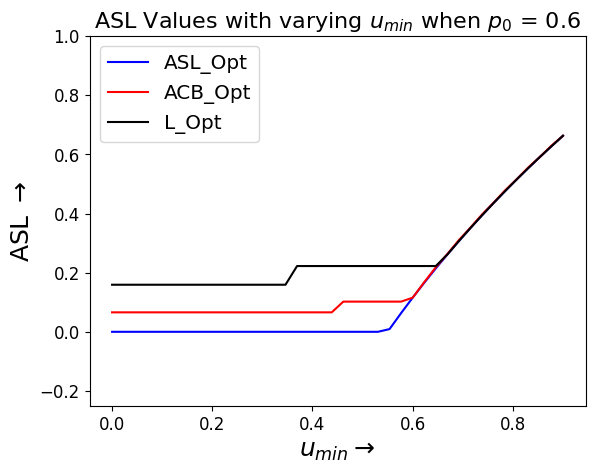

In [14]:
from google.colab import files

plt.figure(0)  
plt.plot(umin_list, MSL1, 'b-', label='MSL_Optimization')
plt.plot(umin_list, MSL2, 'r-', label='MCB_Optimization')
plt.plot(umin_list, MSL3, 'k-', label='ML_Optimization')

plt.ylim([-0.25, 1])

plt.title('ASL Values with varying $u_{min}$ when $p_0$ = 0.6', fontsize = 16)
plt.legend(['ASL_Opt', 'ACB_Opt', 'L_Opt'], loc = 'upper left', fontsize = 'x-large')
plt.xlabel(r'$u_{min} \rightarrow$', fontsize = 18)
plt.ylabel(r'ASL $\rightarrow$', fontsize = 18)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.savefig('MSL_values_case_2_again.png')
files.download('MSL_values_case_2_again.png') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

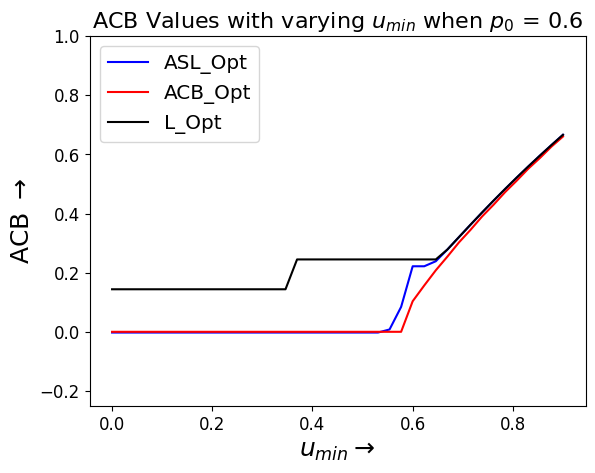

In [15]:
plt.figure(1)    
plt.plot(umin_list, MCB1, 'b-', label='MSL_Optimization')
plt.plot(umin_list, MCB2, 'r-', label='MCB_Optimization')
plt.plot(umin_list, MCB3, 'k-', label='ML_Optimization')

plt.ylim([-0.25, 1])

plt.title('ACB Values with varying $u_{min}$ when $p_0$ = 0.6', fontsize = 16)
plt.legend(['ASL_Opt', 'ACB_Opt', 'L_Opt'], loc = 'upper left', fontsize = 'x-large')
plt.xlabel(r'$u_{min} \rightarrow$', fontsize = 18)
plt.ylabel(r'ACB $\rightarrow$', fontsize = 18)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.savefig('MCB_values_case_2_again.png')
files.download('MCB_values_case_2_again.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

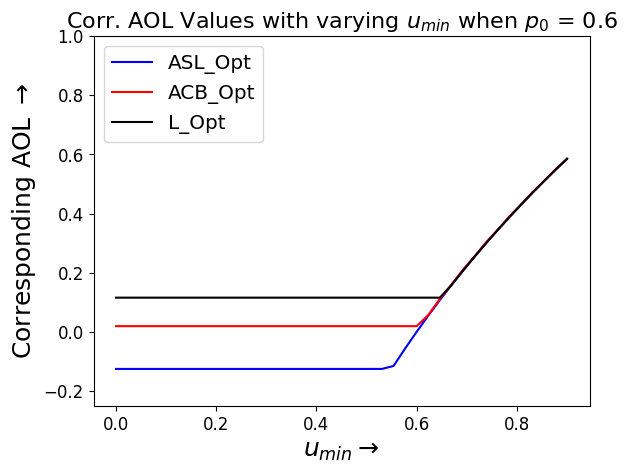

In [16]:
plt.figure(2)    
plt.plot(umin_list, MOLcor1, 'b-', label='MSL_Optimization')
plt.plot(umin_list, MOLcor2, 'r-', label='MCB_Optimization')
plt.plot(umin_list, MOLcor3, 'k-', label='ML_Optimization')

plt.ylim([-0.25, 1])

plt.legend(['ASL_Opt', 'ACB_Opt', 'L_Opt'], loc = 'upper left', fontsize = 'x-large')
plt.title('Corr. AOL Values with varying $u_{min}$ when $p_0$ = 0.6', fontsize = 16)
plt.xlabel(r'$u_{min} \rightarrow$', fontsize = 18)
plt.ylabel(r'Corresponding AOL $\rightarrow$', fontsize = 18)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.savefig('MOL_values_case_2_again.png')
files.download('MOL_values_case_2_again.png')